In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# YOUR CODE HERE (OPTION) 
# If you need other libraries, you can import them here
import seaborn as sns

In [2]:
clean_df = pd.read_csv('../data/processed/processed_data.csv')
clean_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Making questions:

**Question 1:** will the status of patient's life and diseases affect to the probability of stroke?

**Step 1:** we will consider the status of patient's marriage to ask: whether marriage status will influence strongly on the probability of stroke? Additionally, about the place where patient live to ask: if accomodation will also affect to the probability of stroke. Finally, we should consider what type of work does each patient work to draw some conclusion about what factor in patient's daily life affect mostly to the probability of stroke.

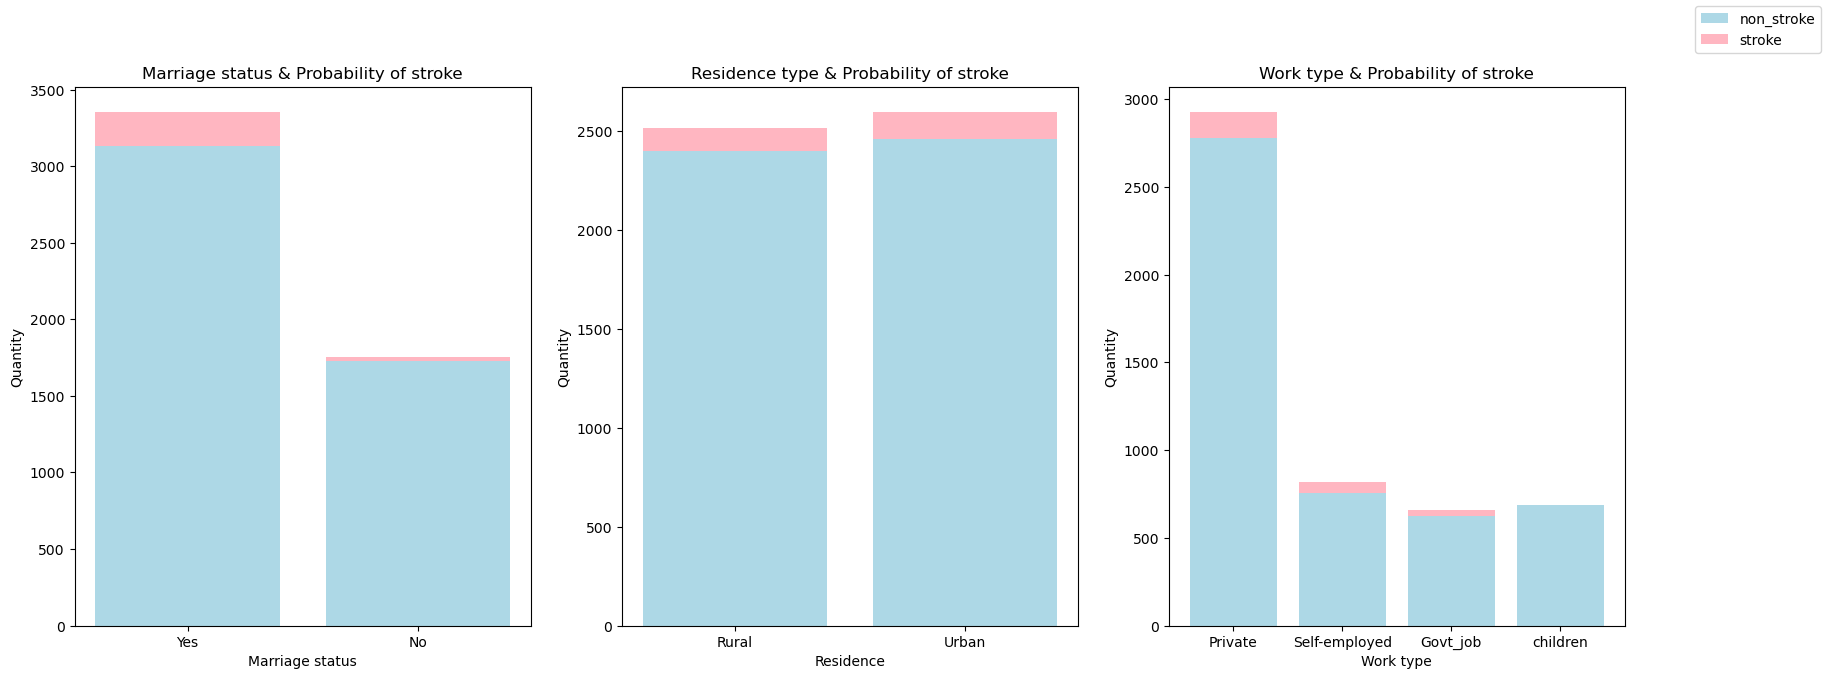

In [3]:
df_copy_stroke = clean_df[clean_df['stroke'] == 1]
df_copy_no_stroke = clean_df[clean_df['stroke'] == 0]

fig, ax = plt.subplots(1, 3, figsize = (20, 7))

freq_stroke = [len(df_copy_stroke[df_copy_stroke['ever_married'] == 'Yes']),
              len(df_copy_stroke[df_copy_stroke['ever_married'] == 'No'])]


freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['ever_married'] == 'Yes']),
                 len(df_copy_no_stroke[df_copy_no_stroke['ever_married'] == 'No'])]

ax[0].bar(['Yes', 'No'], freq_no_stroke, color='lightblue')
ax[0].bar(['Yes', 'No'], freq_stroke, bottom= freq_no_stroke, color='lightpink')
ax[0].set_xlabel('Marriage status')
ax[0].set_ylabel('Quantity')
ax[0].set_title("Marriage status & Probability of stroke")

freq_stroke = [len(df_copy_stroke[df_copy_stroke['Residence_type'] == 'Rural']),
              len(df_copy_stroke[df_copy_stroke['Residence_type'] == 'Urban'])]

freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['Residence_type'] == 'Rural']),
                 len(df_copy_no_stroke[df_copy_no_stroke['Residence_type'] == 'Urban'])]

ax[1].bar(['Rural', 'Urban'], freq_no_stroke, color='lightblue')
ax[1].bar(['Rural', 'Urban'], freq_stroke, bottom= freq_no_stroke, color='lightpink')
ax[1].set_xlabel('Residence')
ax[1].set_ylabel('Quantity')
ax[1].set_title("Residence type & Probability of stroke")

freq_stroke = [len(df_copy_stroke[df_copy_stroke['work_type'] == 'Private']),
              len(df_copy_stroke[df_copy_stroke['work_type'] == 'Self-employed']),
              len(df_copy_stroke[df_copy_stroke['work_type'] == 'Govt_job']),
              len(df_copy_stroke[df_copy_stroke['work_type'] == 'children'])]

freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['work_type'] == 'Private']),
              len(df_copy_no_stroke[df_copy_no_stroke['work_type'] == 'Self-employed']),
              len(df_copy_no_stroke[df_copy_no_stroke['work_type'] == 'Govt_job']),
              len(df_copy_no_stroke[df_copy_no_stroke['work_type'] == 'children'])]
ax[2].bar(['Private', 'Self-employed', 'Govt_job', 'children'], freq_no_stroke, color='lightblue')
ax[2].bar(['Private', 'Self-employed', 'Govt_job', 'children'], freq_stroke, bottom= freq_no_stroke, color='lightpink')
ax[2].set_xlabel('Work type')
ax[2].set_ylabel('Quantity')
ax[2].set_title("Work type & Probability of stroke")
labels = ['non_stroke', 'stroke']
fig.legend(labels)

**Observation:** As we can see apparently that patient's residence affects very little to the probability of stroke, because the proportion of stroke in `rural` and `urban`are nearly the same. However, in term of `marriage status` and `type of work`, they seem to affect a lots to the probability of stroke. It is because there are are big differences between the patient who has a family and patient in different type of work. Specifically, patient who has married or worked for private job will be more likely to get stroke.

**Step 2:** we will consider the medical history of patient then ask: which disease will mostly affect to the probability of stroke?

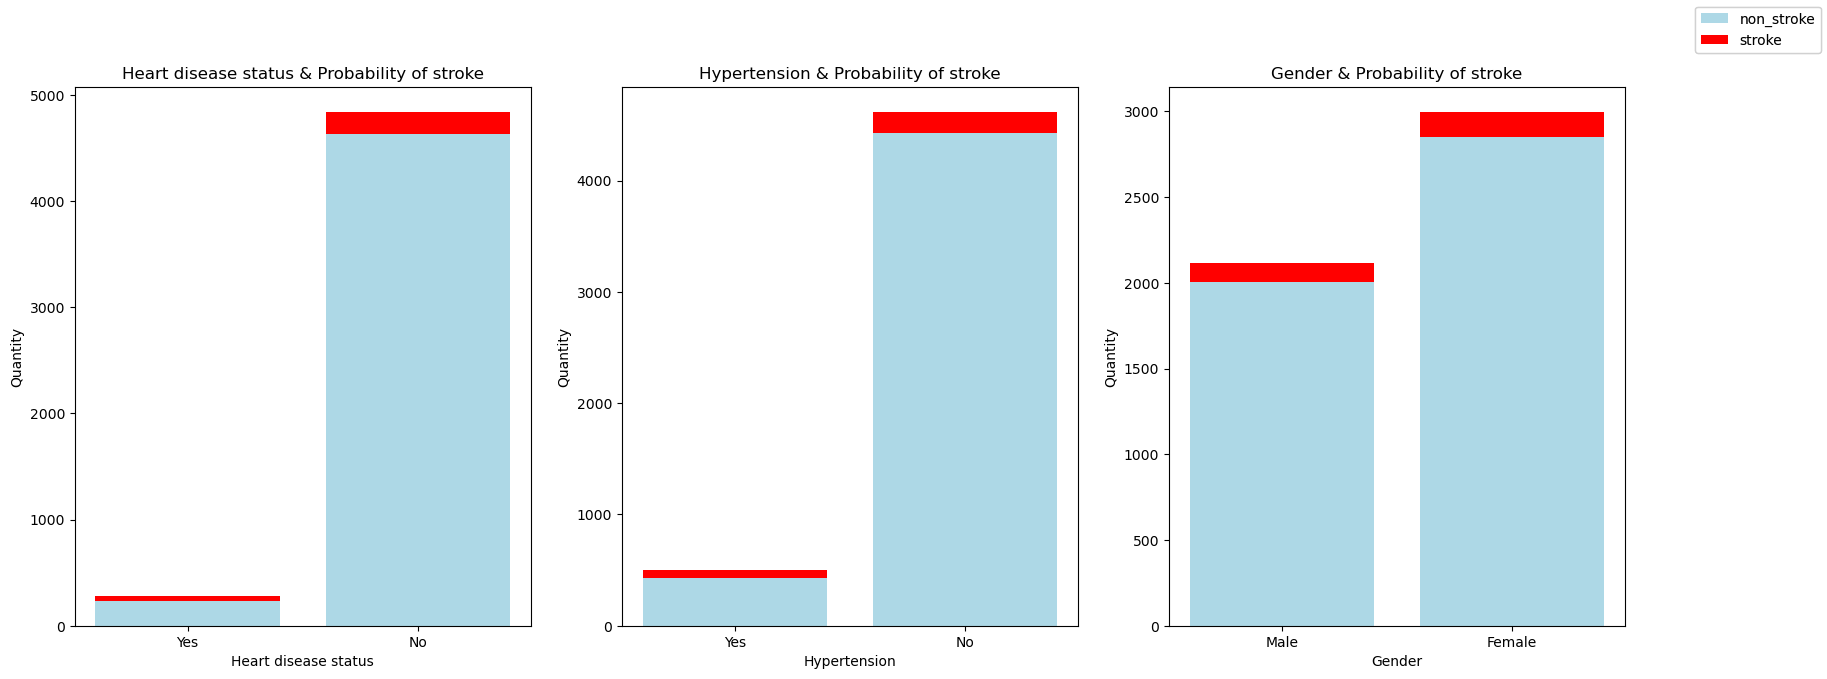

In [82]:
fig, ax = plt.subplots(1, 3, figsize = (20, 7))

freq_stroke = [len(df_copy_stroke[df_copy_stroke['heart_disease'] == 1]),
              len(df_copy_stroke[df_copy_stroke['heart_disease'] == 0])]


freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['heart_disease'] == 1]),
                 len(df_copy_no_stroke[df_copy_no_stroke['heart_disease'] == 0])]

ax[0].bar(['Yes', 'No'], freq_no_stroke, color='lightblue')
ax[0].bar(['Yes', 'No'], freq_stroke, bottom= freq_no_stroke, color='red')
ax[0].set_xlabel('Heart disease status')
ax[0].set_ylabel('Quantity')
ax[0].set_title("Heart disease status & Probability of stroke")

freq_stroke = [len(df_copy_stroke[df_copy_stroke['hypertension'] == 1]),
              len(df_copy_stroke[df_copy_stroke['hypertension'] == 0])]

freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['hypertension'] == 1]),
                 len(df_copy_no_stroke[df_copy_no_stroke['hypertension'] == 0])]

ax[1].bar(['Yes', 'No'], freq_no_stroke, color='lightblue')
ax[1].bar(['Yes', 'No'], freq_stroke, bottom= freq_no_stroke, color='red')
ax[1].set_xlabel('Hypertension')
ax[1].set_ylabel('Quantity')
ax[1].set_title("Hypertension & Probability of stroke")
labels = ['non_stroke', 'stroke']
fig.legend(labels)

freq_stroke = [len(df_copy_stroke[df_copy_stroke['gender'] == 'Male']),
              len(df_copy_stroke[df_copy_stroke['gender'] == 'Female'])]

freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['gender'] == 'Male']),
                 len(df_copy_no_stroke[df_copy_no_stroke['gender'] == 'Female'])]
ax[2].bar(['Male', 'Female'], freq_no_stroke, color='lightblue')
ax[2].bar(['Male', 'Female'], freq_stroke, bottom= freq_no_stroke, color='red')
ax[2].set_xlabel('Gender')
ax[2].set_ylabel('Quantity')
ax[2].set_title("Gender & Probability of stroke")
labels = ['non_stroke', 'stroke']
fig.legend(labels)

**Observation:** Generally, 

**Conclusion:**



**Question 2:** 

**Answering this question will** help 

**How we can answer this question:**

In [5]:
clean_df[clean_df['age'] == 0].shape

(43, 12)

**Question 3:** 

**Answering this question will** help 

**How we can answer this question:**

hypertension
0.153, 0.04
marriage
0.070, 0.017


In [6]:
freq_stroke = [len(df_copy_stroke[df_copy_stroke['heart_disease'] == 1]),
              len(df_copy_stroke[df_copy_stroke['heart_disease'] == 0])]


freq_no_stroke = [len(df_copy_no_stroke[df_copy_no_stroke['heart_disease'] == 1]),
                 len(df_copy_no_stroke[df_copy_no_stroke['heart_disease'] == 0])]


freq_stroke[0] / freq_no_stroke[0], freq_stroke[1] / freq_no_stroke[1]

(0.2052401746724891, 0.043609671848013815)

tai sao o urban thi stroke lai cao hon so voi o rural.
nguyen nhan khach quan: disease, work_type.

- cac yeu to nao anh huong nhieu nhat den kha nang bi stroke o Nam va Nu?

**Question 1:** What factors will affect most to the probability of stroke between male and female?

**Answering this question will** 

**How can we answer this question:**

Step 1: We will pick out people who are stroke

In [7]:
stroke_df = clean_df[clean_df['stroke'] == 1]
stroke_df.drop(columns='stroke',inplace=True)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


step 2: 

In [8]:
stroke_male_df = stroke_df.loc[(stroke_df['gender'] == 'Male') & (stroke_df['hypertension'] == 1), :]
stroke_female_df = stroke_df[stroke_df['gender'] == 'Female']
# stroke_male_df

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import sklearn.preprocessing

from tensorflow import keras
import tensorflow as tf 

2023-12-22 09:34:33.938346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 09:34:33.938374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 09:34:33.965962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 09:34:34.025325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 09:34:34.910839: W tensorflow/compiler/tf2

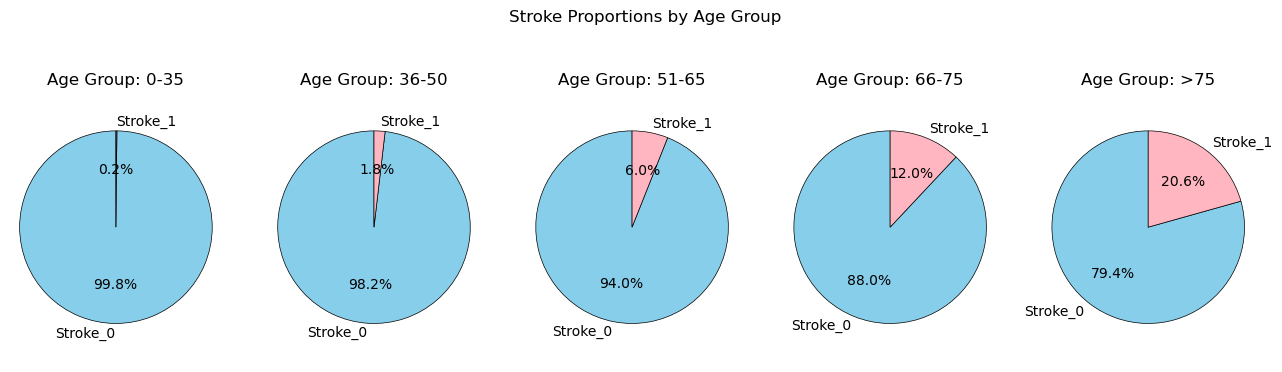

In [10]:
# clean_df = clean_df[clean_df['age_group'] > 0]
clean_df['age_group'] = pd.cut(clean_df['age'], bins=[0,35,50,65,75,np.inf],labels=['0-35','36-50','51-65','66-75','>75'])
cross_tab = pd.crosstab(clean_df['age_group'],clean_df['stroke'])
probability = cross_tab.div(cross_tab.sum(axis=1),axis=0)

age_groups = ['0-35', '36-50', '51-65', '66-75', '>75']
colors = ['skyblue', 'lightpink']
fig, ax = plt.subplots(nrows=1,ncols=len(probability.values),figsize=(13, 3.5))
plt.suptitle('Stroke Proportions by Age Group', y=1.05)

for i, row in enumerate(probability.values):
    ax[i].pie(row,labels=['Stroke_0', 'Stroke_1'],colors=colors,autopct='%1.1f%%',startangle=90,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
    ax[i].set_title(f'Age Group: {age_groups[i]}')
    ax[i].axis('equal')

plt.tight_layout()
plt.show()

In [11]:
clean_df = clean_df[clean_df['gender'] != 'Other']
clean_df['gender_age_group'] = clean_df['gender'].astype(str) + '_' + clean_df['age_group'].astype(str)
clean_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,gender_age_group
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,66-75,Male_66-75
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,51-65,Female_51-65
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,>75,Male_>75
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,36-50,Female_36-50
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,>75,Female_>75


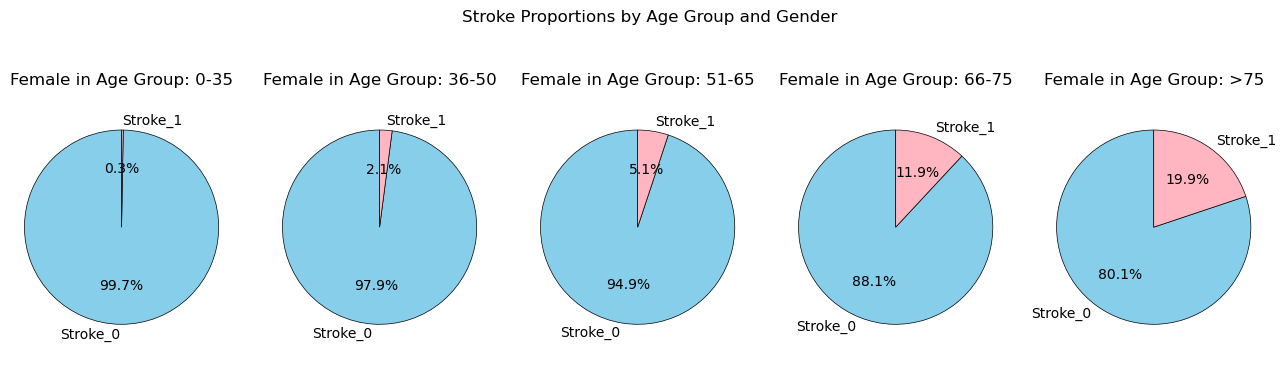

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=len(female_props.values),figsize=(13, 3.5))
plt.suptitle('Stroke Proportions by Age Group and Gender', y=1.05)

for i, row in enumerate(female_props.values):
    ax[i].pie(row,labels=['Stroke_0', 'Stroke_1'],colors=colors,autopct='%1.1f%%',startangle=90,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
    ax[i].set_title(f'Female in Age Group: {age_groups[i]}')
    ax[i].axis('equal')

plt.tight_layout()
plt.show()

In [17]:
clean_df['comorbidities'] = ((clean_df['hypertension'] == 1).astype(int) +
                             (clean_df['avg_glucose_level'] > 140).astype(int) +
                             (clean_df['heart_disease'] == 1).astype(int) +
                             (clean_df['bmi'] > 30).astype(int))
comorbidities_df = clean_df.groupby(['age_group', 'comorbidities'],observed=True)['stroke'].mean().unstack(fill_value=0)
comorbidities_df

comorbidities,0,1,2,3,4
age_group,,,,,
0-35,0.001491,0.002083,0.000000,0.000000,0.000000
36-50,0.018443,0.011086,0.037313,0.090909,0.000000
51-65,0.047146,0.050314,0.086538,0.115942,0.200000
66-75,0.106250,0.079545,0.160714,0.177778,0.428571
>75,0.195946,0.198895,0.228261,0.214286,0.500000


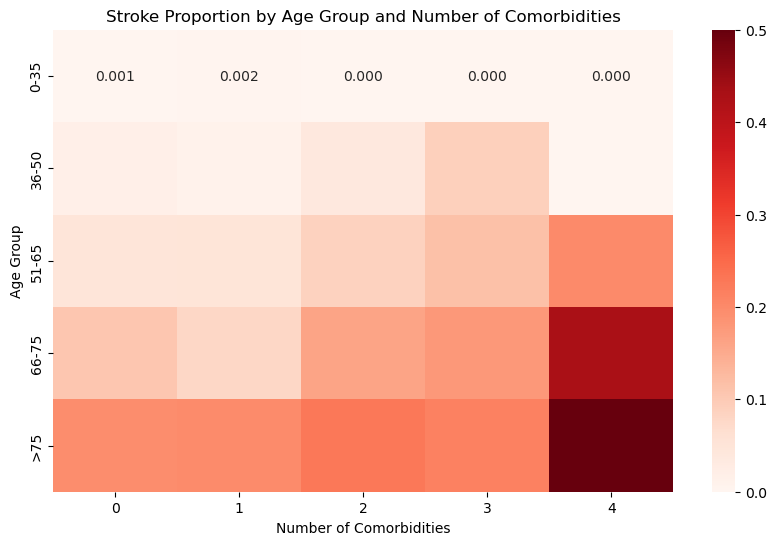

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(comorbidities_df,annot=True,cmap='Reds',fmt=".3f")
plt.title('Stroke Proportion by Age Group and Number of Comorbidities')
plt.ylabel('Age Group')
plt.xlabel('Number of Comorbidities')
plt.show()

**Question 1:** Based on this dataset, How can we learn the general knowledge of stroke?

**Purpose of this question:** Give us general knowledge about stroke.

**How we can answer this question:** 

Step 1: We will represent the proportion and number of people who suffered from `Stroke` to have a general view of this dataset.

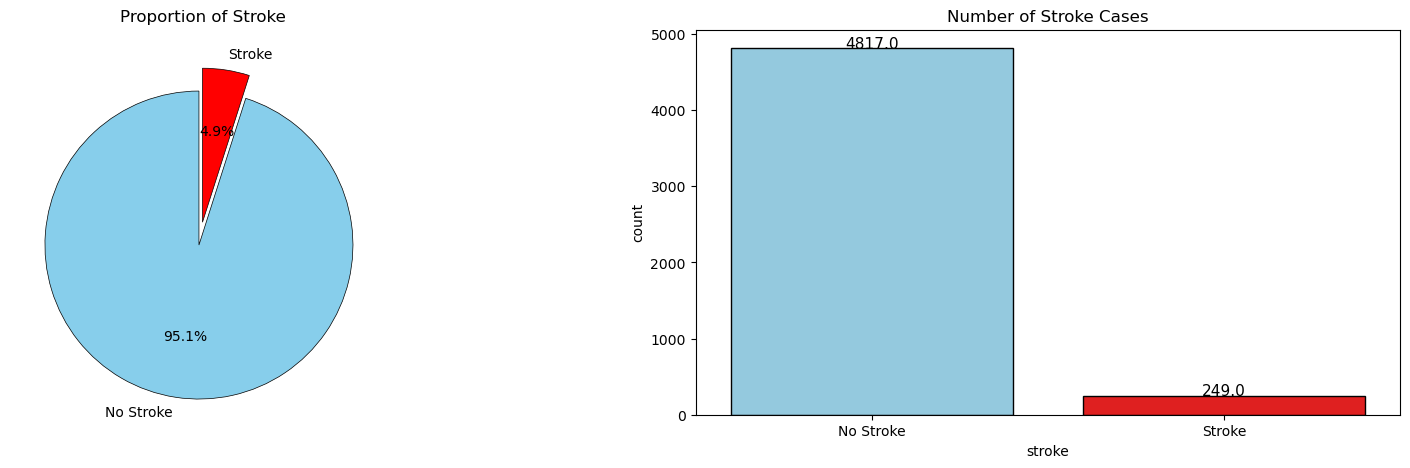

In [81]:
cross_tab = clean_df['stroke'].value_counts()
proportion = (cross_tab / len(clean_df) * 100).to_numpy()
fig = plt.subplots(nrows=1,ncols=2,figsize=(20,5))

plt.subplot(1,2,1)
plt.pie(proportion,labels=['No Stroke', 'Stroke'],autopct='%1.1f%%',startangle=90,explode=(0.15,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
plt.title('Proportion of Stroke')

plt.subplot(1,2,2)
ax = sns.countplot(data=clean_df,x='stroke',palette=colors,edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['No Stroke','Stroke'])
plt.title('Number of Stroke Cases');
plt.show()

Step 2: we will show some means of each numeric columns by using `pd.describe()` and transpose it to easily extract this information

In [132]:
stroke_df, none_stroke_df = clean_df[clean_df['stroke'] == 1].describe().T, clean_df[clean_df['stroke'] == 0].describe().T

Step 3: we will visualize the information above for everyone can understand as well as observe it much more easily.

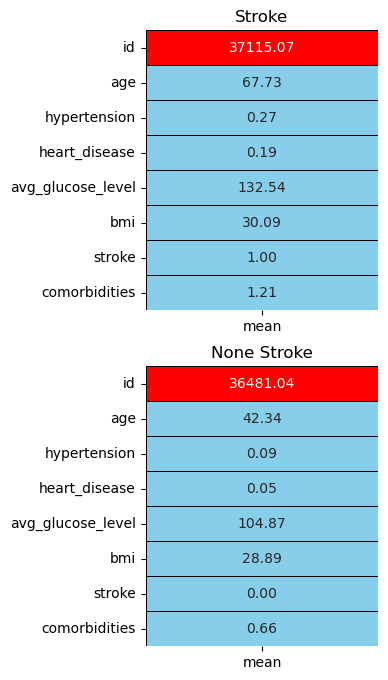

In [48]:
colors = ['skyblue','red']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3,8))

plt.subplot(2,1,1)
sns.heatmap(stroke_df[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke')

plt.subplot(2,1,2)
sns.heatmap(none_stroke_df[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('None Stroke');

**Observation**:

Step 3: Next, we will create a dataframe of people who suffered from `Stroke` to analyze it more deeply.

In [113]:
stroke_df = clean_df[clean_df['stroke'] == 1]

In [12]:
clean_df = clean_df.loc[clean_df['age_group'].notna(),:]
cross_tab = pd.crosstab(clean_df['gender_age_group'],clean_df['stroke'])
probability = cross_tab.div(cross_tab.sum(axis=1),axis=0)
female_props = probability.loc[probability.index.str.startswith('F'), :]
male_props = probability.loc[probability.index.str.startswith('M'), :]

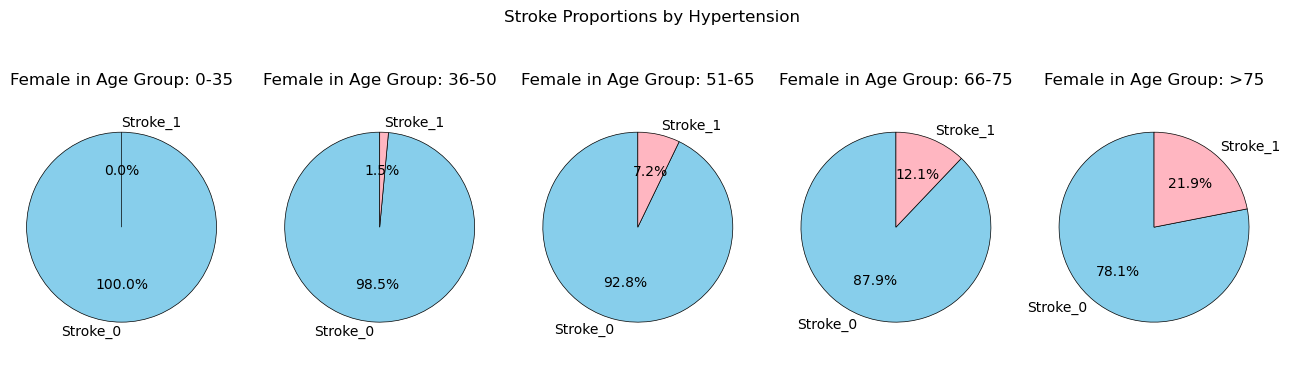

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=len(male_props.values),figsize=(13, 3.5))
plt.suptitle('Stroke Proportions by Hypertension', y=1.05)

for i, row in enumerate(male_props.values):
    ax[i].pie(row,labels=['Stroke_0', 'Stroke_1'],colors=colors,autopct='%1.1f%%',startangle=90,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
    ax[i].set_title(f'Female in Age Group: {age_groups[i]}')
    ax[i].axis('equal')

plt.tight_layout()
plt.show()

In [97]:
gender_prop = (stroke_df['gender'].value_counts() / len(stroke_df) * 100).to_numpy()
hypertension_prop = (stroke_df['hypertension'].value_counts() / len(stroke_df) * 100).to_numpy()
heart_disease_prop = (stroke_df['heart_disease'].value_counts() / len(stroke_df) * 100).to_numpy()
married_prop = (stroke_df['ever_married'].value_counts() / len(stroke_df) * 100).to_numpy()
work_type_prop = (stroke_df['work_type'].value_counts() / len(stroke_df) * 100).to_numpy()
residence_prop = (stroke_df['Residence_type'].value_counts() / len(stroke_df) * 100).to_numpy()
proportions = [gender_prop,hypertension_prop,heart_disease_prop,married_prop,work_type_prop,residence_prop]
proportions

[array([56.62650602, 43.37349398]),
 array([73.4939759, 26.5060241]),
 array([81.12449799, 18.87550201]),
 array([88.35341365, 11.64658635]),
 array([59.83935743, 26.10441767, 13.25301205,  0.80321285]),
 array([54.21686747, 45.78313253])]

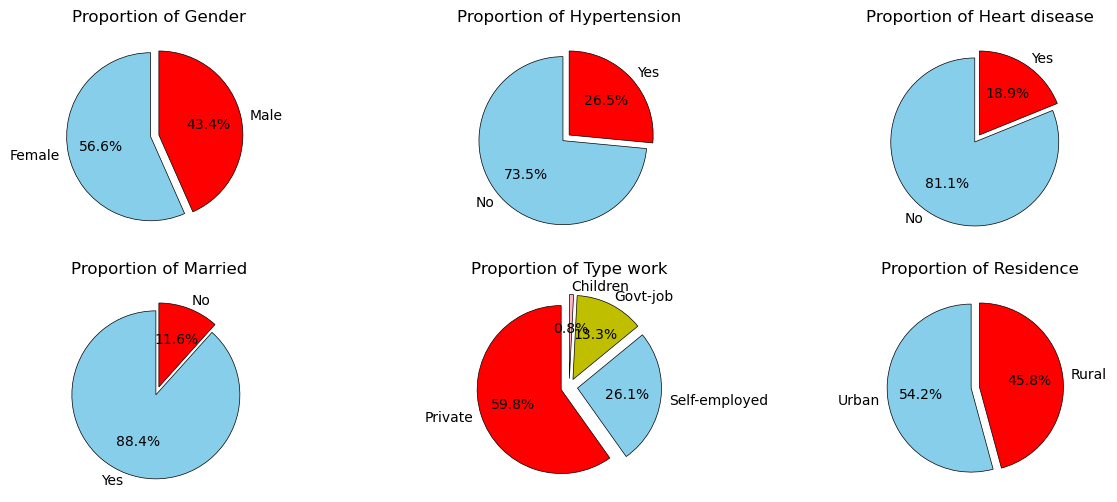

In [135]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,6))

ax[0,0].pie(proportions[0],labels=['Female', 'Male'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[0,0].set_title('Proportion of Gender')

ax[0,1].pie(proportions[1],labels=['No', 'Yes'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[0,1].set_title('Proportion of Hypertension')

ax[0,2].pie(proportions[2],labels=['No', 'Yes'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[0,2].set_title('Proportion of Heart disease')

ax[1,0].pie(proportions[3],labels=['Yes', 'No'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[1,0].set_title('Proportion of Married')

ax[1,1].pie(proportions[4],labels=['Private', 'Self-employed','Govt-job','Children'],autopct='%1.1f%%',startangle=90,explode=(0.1,0.1,0.1,0.1),colors=['r','skyblue','y','lightpink'],wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[1,1].set_title('Proportion of Type work')

ax[1,2].pie(proportions[5],labels=['Urban', 'Rural'],autopct='%1.1f%%',startangle=90,explode=(0.1,0),colors=colors,wedgeprops={'edgecolor':'black','linewidth':0.5,'antialiased':True})
ax[1,2].set_title('Proportion of Residence');